# TRABAJO DEM DE COPERNICUS CON AWS

Refs: 
- https://copernicus-dem-30m.s3.amazonaws.com/readme.html
- https://docs.sentinel-hub.com/api/latest/data/dem/ (Pero no se esta usando el Sentinel Hub)

Installs

In [1]:
%pip install -q boto3 rasterio simplekml

Note: you may need to restart the kernel to use updated packages.


Imports

In [2]:
import math
import json
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import simplekml


# PARA DESCARGAR

Poligono formato de https://geojson.io

Esto fue sacado para pruebas. Se puede implementar recursivamente para trabajar con una BBOX

In [3]:
data_json = '''

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -70.8558188103709,
              -34.386431136315004
            ],
            [
              -69.94995620681529,
              -34.386431136315004
            ],
            [
              -69.94995620681529,
              -33.750419861406904
            ],
            [
              -70.8558188103709,
              -33.750419861406904
            ],
            [
              -70.8558188103709,
              -34.386431136315004
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
'''

In [4]:
# Convertir el string JSON a un diccionario
data = json.loads(data_json)

# Extracción de las coordenadas
coords = data['features'][0]['geometry']['coordinates'][0]
min_lon = min([point[0] for point in coords])
max_lon = max([point[0] for point in coords])
min_lat = min([point[1] for point in coords])
max_lat = max([point[1] for point in coords])

# Imprimir las coordenadas mínimas y máximas del BBOX
print(f"min_lon, min_lat = {min_lon}, {min_lat}")
print(f"max_lon, max_lat = {max_lon}, {max_lat}")

min_lon, min_lat = -70.8558188103709, -34.386431136315004
max_lon, max_lat = -69.94995620681529, -33.750419861406904


In [5]:
# Generar punto medio del BBOX

mid_lon = (min_lon + max_lon) / 2
mid_lat = (min_lat + max_lat) / 2
print(mid_lat, mid_lon)

-34.068425498860954 -70.4028875085931


### Funciones para generar los tiles y 'consultar' AWS

In [6]:
# Función para encontrar el nombre del tile correspondiente a un punto
def find_tile_for_point(lon, lat, resolution):
    """Calcula el nombre del tile basado en latitud y longitud."""
    northing_prefix = 'N' if lat >= 0 else 'S'
    easting_prefix = 'E' if lon >= 0 else 'W'
    northing = f"{northing_prefix}{abs(math.floor(lat)):02d}_00"
    easting = f"{easting_prefix}{abs(math.floor(lon)):03d}_00"
    tile_name = f"Copernicus_DSM_COG_10_{northing}_{easting}_DEM/Copernicus_DSM_COG_10_{northing}_{easting}_DEM.tif"
    return tile_name

# Función para descargar un tile específico desde S3
def download_tile(bucket, tile_name):
    """Descarga un tile desde S3 y lo guarda localmente con su nombre original."""
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    local_filename = tile_name.split('/')[-1]  # Obtener el nombre del archivo
    try:
        s3.download_file(bucket, tile_name, local_filename)
        print(f"Descargado y guardado como: {local_filename}")
        return local_filename
    except Exception as e:
        print(f"No se pudo descargar {tile_name}: {e}")
        return None

### Buscar y descargar

Se descarga el tile del punto medio

In [7]:
resolution = "30"  # Puede ser "30" para GLO-30 o "90" para GLO-90

# Identificar y descargar el tile relevante
tile_name = find_tile_for_point(mid_lon, mid_lat, resolution)
bucket_name = 'copernicus-dem-30m' if resolution == "30" else 'copernicus-dem-90m'

# Descargar el tile y obtener el nombre del archivo local

DEMFILE = download_tile(bucket_name, tile_name)

Descargado y guardado como: Copernicus_DSM_COG_10_S35_00_W071_00_DEM.tif


Consultar DEM file

In [8]:
with rasterio.open(DEMFILE) as src:
    print("Metadatos:", src.meta)
    print("Sistema de coordenadas:", src.crs)
    print("Bounds:", src.bounds)
    print("Resolución:", src.res)
    row, col = src.index(mid_lon, mid_lat)
    elevation = src.read(1)[row, col]
    demdata = src.read(1)
    print(f"La elevación en el punto medio lon:({mid_lon}, lat:{mid_lat}) es {elevation} metros")

Metadatos: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3600, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -71.00013888888888,
       0.0, -0.0002777777777777778, -33.99986111111111)}
Sistema de coordenadas: EPSG:4326
Bounds: BoundingBox(left=-71.00013888888888, bottom=-34.99986111111111, right=-70.00013888888888, top=-33.99986111111111)
Resolución: (0.0002777777777777778, 0.0002777777777777778)
La elevación en el punto medio lon:(-70.4028875085931, lat:-34.068425498860954) es 2838.27392578125 metros


Resultados solos

In [9]:
print(mid_lat, mid_lon)
print(elevation)

-34.068425498860954 -70.4028875085931
2838.274


Visualizar

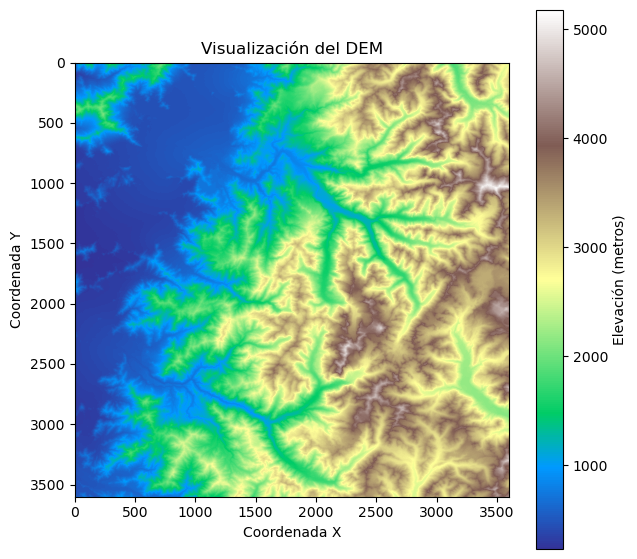

In [10]:
plt.figure(figsize=(7, 7))
plt.imshow(demdata, cmap='terrain')
plt.colorbar(label='Elevación (metros)')
plt.title('Visualización del DEM')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.show()

## Exportar a KML para revisar

In [11]:
coordinates = data['features'][0]['geometry']['coordinates'][0]

#Create a KML file
kml = simplekml.Kml()

# Create a polygon
pol = kml.newpolygon(name=DEMFILE)
pol.outerboundaryis = coordinates
pol.style.polystyle.color = simplekml.Color.changealphaint(50, simplekml.Color.red)  # Semi-transparent green

# Add a point marking the midpoint
midpoint = kml.newpoint(name="Punto medio consultado", coords=[(mid_lon, mid_lat)])
midpoint.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
midpoint.style.iconstyle.scale = 1.2  # Optional: adjust the size of the icon

# Save the KML
kml_file_name = DEMFILE.split('.')[0] + '.kml'  # Create KML filename using DEMFILE's base name
kml.save(kml_file_name)
print(f"KML file saved as '{kml_file_name}'")

KML file saved as 'Copernicus_DSM_COG_10_S35_00_W071_00_DEM.kml'
